# Optimized Wikipedia Article Analysis Pipeline

This notebook implements an optimized version of the Wikipedia article analysis pipeline with parallelization and improved error handling for better performance and stability with large datasets.


In [3]:
# Import required libraries
import requests
import pandas as pd
import spacy
from textstat import textstat
import re
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
import pickle
import os
import time
from tqdm.auto import tqdm
from dateutil import parser
import numpy as np

# Import our parallel processing utilities
from parallel import (
    process_batch_with_progress,
    process_dataframe_parallel,
    gpu_batch_process,
    resilient_api_call,
    CheckpointManager
)


C:\Users\david\anaconda3\envs\wiki\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.7.1+cu118
CUDA version: 11.8
CUDA available: True
GPU count: 1
GPU name: NVIDIA GeForce RTX 2070 with Max-Q Design


In [5]:
# Load GPT-2 model
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()
if torch.cuda.is_available():
    print("CUDA available! Moving model to GPU...")
    model.to("cuda")
else:
    print('CUDA not available! Using CPU (this will be slow).')


CUDA available! Moving model to GPU...


## 1. Wikipedia API Functions with Improved Resilience


In [6]:
def get_category_members(category, cmtype="page", namespace=0, limit=500):
    """
    Fetches members of a given Wikipedia category with improved error handling.

    Args:
        category: Category name without the 'Category:' prefix
        cmtype: 'page', 'subcat', or 'file'
        namespace: Namespace index (0 for articles)
        limit: Number of results per request (max 500 for users)

    Returns:
        List of dicts with 'pageid' and 'title'
    """

    def api_call(**params):
        S = requests.Session()
        res = S.get("https://en.wikipedia.org/w/api.php", params=params, timeout=30)
        res.raise_for_status()
        return res.json()

    members = []
    params = {
        "action": "query",
        "format": "json",
        "list": "categorymembers",
        "cmtitle": f"Category:{category}",
        "cmtype": cmtype,
        "cmlimit": limit,
        "cmnamespace": namespace,
    }

    while True:
        try:
            # Use our resilient API call function with retries
            data = resilient_api_call(api_call, max_retries=5, **params)
            batch = data.get("query", {}).get("categorymembers", [])
            members.extend(batch)

            if "continue" in data:
                params.update(data["continue"])
            else:
                break
        except Exception as e:
            print(f"Error fetching category members for {category}: {str(e)}")
            break

    return members


In [7]:
def fetch_articles_from_categories(categories, include_subcats=False, max_subcat_depth=1, checkpoint_path=None):
    """
    Given a list of category names, fetches all articles in them with checkpointing.
    Optionally includes pages from subcategories up to specified depth.

    Args:
        categories: List of category names (strings without prefix)
        include_subcats: Whether to traverse into subcategories
        max_subcat_depth: Maximum depth for subcategory traversal
        checkpoint_path: Path to save checkpoint data

    Returns:
        Set of page titles
    """
    # Initialize checkpoint manager if path provided
    checkpoint_mgr = None
    if checkpoint_path:
        checkpoint_mgr = CheckpointManager(checkpoint_path, save_interval=10)
        # If we have completed results, return them
        if checkpoint_mgr.processed_count == len(categories):
            all_articles = set()
            for result in checkpoint_mgr.get_results():
                all_articles.update(result)
            return all_articles

    all_articles = set()
    seen_cats = set()

    def _recurse(cat, depth):
        if cat in seen_cats or depth < 0:
            return set()
        seen_cats.add(cat)

        cat_articles = set()

        # Fetch pages
        pages = get_category_members(cat, cmtype="page")
        for p in pages:
            cat_articles.add(p["title"])

        if include_subcats and depth > 0:
            subcats = get_category_members(cat, cmtype="subcat", namespace=14)
            for sc in subcats:
                sc_name = sc["title"].replace("Category:", "")
                subcat_articles = _recurse(sc_name, depth - 1)
                cat_articles.update(subcat_articles)

        return cat_articles

    # Process categories in parallel
    def process_category(cat):
        try:
            return _recurse(cat, max_subcat_depth)
        except Exception as e:
            print(f"Error processing category {cat}: {str(e)}")
            return set()

    # Get pending categories if using checkpoints
    if checkpoint_mgr:
        pending_indices = checkpoint_mgr.get_pending_indices(len(categories))
        pending_categories = [categories[i] for i in pending_indices]
        print(f"Processing {len(pending_categories)} pending categories out of {len(categories)} total")
    else:
        pending_categories = categories

    # Process categories in parallel
    results = process_batch_with_progress(
        process_category,
        pending_categories,
        desc="Traversing categories",
        use_threads=True,  # Use threads for I/O-bound tasks
        cpu_intensive=False
    )

    # Save results to checkpoint if using checkpoints
    if checkpoint_mgr:
        for i, result in enumerate(results):
            idx = pending_indices[i] if pending_indices else i
            checkpoint_mgr.add_result(idx, result)

        # Get all results including previously checkpointed ones
        all_results = checkpoint_mgr.get_results()
    else:
        all_results = results

    # Combine all article sets
    for article_set in all_results:
        if article_set:  # Skip None results from errors
            all_articles.update(article_set)

    return all_articles


In [8]:
def fetch_revision_snapshots(
        title: str,
        start_ts: str,
        end_ts: str,
        freq: str = "7D",
        bot_test_fn: callable = None,
        carry_forward: bool = True,
        max_retries: int = 5,
        backoff_factor: float = 1.0,
        checkpoint_path: str = None,
) -> pd.DataFrame:
    """
    Fetches all revisions (including full content) for `title` between start_ts and end_ts,
    then returns snapshots at given frequency with content included.

    This version includes improved error handling and checkpointing.

    Args:
        title: Wikipedia page title
        start_ts: ISO8601 timestamp string, e.g. "2020-01-01T00:00:00Z"
        end_ts: ISO8601 timestamp string, e.g. "2020-12-31T23:59:59Z"
        freq: pandas offset alias (e.g. "7D")
        bot_test_fn: callable to flag bots (user->bool)
        carry_forward: reuse last snapshot if no newer revision
        max_retries: number of retries on network failure
        backoff_factor: multiplier for retry backoff in seconds
        checkpoint_path: path to pickle intermediate results

    Returns:
        DataFrame with columns ['page_title','snapshot_ts','rev_id','timestamp',
        'user','is_bot','content']
    """
    # Check if we have a checkpoint
    if checkpoint_path and os.path.exists(checkpoint_path):
        try:
            return pd.read_pickle(checkpoint_path)
        except Exception as e:
            print(f"Error loading checkpoint: {str(e)}")

    def api_call(**params):
        session = requests.Session()
        resp = session.get("https://en.wikipedia.org/w/api.php", params=params, timeout=30)
        resp.raise_for_status()
        return resp.json()

    # Phase 1: Fetch metadata + content in one pass
    params = {
        "action": "query",
        "format": "json",
        "prop": "revisions",
        "rvprop": "ids|timestamp|user|content",
        "rvstart": end_ts,
        "rvend": start_ts,
        "rvlimit": "max",
        "titles": title,
        "redirects": 1,
        "rvslots": "main",
    }

    all_revs = []

    try:
        while True:
            # Use our resilient API call function
            data = resilient_api_call(
                api_call,
                max_retries=max_retries,
                initial_backoff=backoff_factor,
                **params
            )

            pages = data.get("query", {}).get("pages", {})
            for page in pages.values():
                for rev in page.get("revisions", []) or []:
                    ts_str = rev.get("timestamp")
                    if not ts_str:
                        continue
                    ts = parser.isoparse(ts_str)
                    user = rev.get("user", "")
                    # content slot
                    content = rev.get("slots", {}).get("main", {}).get("*", "")
                    all_revs.append({
                        "rev_id": rev.get("revid"),
                        "timestamp": ts,
                        "user": user,
                        "is_bot": bot_test_fn(user) if bot_test_fn else False,
                        "content": content,
                    })

            if "continue" in data:
                params.update(data["continue"])
            else:
                break
    except Exception as e:
        print(f"Error fetching revisions for {title}: {str(e)}")
        # If we have some revisions, continue with what we have
        if not all_revs:
            return pd.DataFrame(columns=["page_title", "snapshot_ts", "rev_id",
                                         "timestamp", "user", "is_bot", "content"])

    # If no revisions, return empty DataFrame
    if not all_revs:
        return pd.DataFrame(columns=["page_title", "snapshot_ts", "rev_id",
                                     "timestamp", "user", "is_bot", "content"])

    # Build DataFrame and sort
    df = pd.DataFrame(all_revs)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Phase 2: Snapshot selection
    timestamps = df["timestamp"]
    sample_times = pd.date_range(
        start=pd.to_datetime(start_ts),
        end=pd.to_datetime(end_ts),
        freq=freq,
        tz=timestamps.dt.tz
    )

    snaps = []
    last_snap_time = None

    for snap_t in sample_times:
        pos = timestamps.searchsorted(snap_t, side='right') - 1
        if pos < 0:
            continue
        rev_time = timestamps.iloc[pos]
        # skip if no carry_forward and no new revision
        if not carry_forward and last_snap_time is not None and rev_time <= last_snap_time:
            last_snap_time = snap_t
            continue
        row = df.iloc[pos].to_dict()
        row["snapshot_ts"] = snap_t
        row["page_title"] = title
        snaps.append(row)
        last_snap_time = snap_t

    df_snap = pd.DataFrame(snaps)
    cols = ["page_title", "snapshot_ts", "rev_id", "timestamp", "user", "is_bot", "content"]
    result_df = df_snap[cols] if not df_snap.empty else pd.DataFrame(columns=cols)

    # Save checkpoint if path provided
    if checkpoint_path and not result_df.empty:
        try:
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            result_df.to_pickle(checkpoint_path)
        except Exception as e:
            print(f"Error saving checkpoint: {str(e)}")

    return result_df


## 2. Fetch Articles from Categories


In [12]:
# Modify parallel processing configuration
from parallel import process_batch_with_progress

# Define categories to fetch
categories = [
    "Politics",
    "History"
]

# Create checkpoint directory
os.makedirs("checkpoints", exist_ok=True)

# Configure more conservative parallel processing settings
PARALLEL_CONFIG = {
    'max_workers': 4,  # Reduce number of concurrent workers
    'use_threads': True,  # Use threads instead of processes for API calls
    'cpu_intensive': False,
    'timeout': 300,  # 5 minutes timeout
    'chunk_size': 5  # Process in smaller chunks
}


# Fetch articles with improved error handling
def fetch_with_retries(category, **kwargs):
    try:
        results = fetch_articles_from_categories(
            [category],
            include_subcats=True,
            max_subcat_depth=2
        )
        return results
    except Exception as e:
        print(f"Error processing category {category}: {str(e)}")
        return set()


# Process categories with more robust error handling
articles = set()
results = process_batch_with_progress(
    fetch_with_retries,
    categories,
    desc="Processing categories",
    **PARALLEL_CONFIG
)

# Combine results
for result in results:
    if result:
        articles.update(result)

print(f"Fetched {len(articles)} articles from categories and subcategories.")

# Save to file with error handling
try:
    with open("FINAL_NO_RECURSE_article_names_list.pkl", "wb") as f:
        pickle.dump(articles, f)
    print("Successfully saved articles list")
except Exception as e:
    print(f"Error saving articles list: {str(e)}")


Processing 2 items with 4 workers


Processing categories:   0%|          | 0/2 [00:00<?, ?it/s]

Processing 1 items with 4 workers


Traversing categories:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1 items with 4 workers


Traversing categories:   0%|          | 0/1 [00:00<?, ?it/s]

Fetched 29306 articles from categories and subcategories.
Successfully saved articles list


In [73]:
# Load the articles from the saved file if needed
try:
    with open("article_names_list.pkl", "rb") as f:
        articles = pickle.load(f)
    print(f"Loaded {len(articles)} articles from file.")
except FileNotFoundError:
    print("Article list file not found.")


Loaded 29306 articles from file.


In [66]:
# load from all_articles_by_category.csv if available
try:
    articles_df = pd.read_csv("all_articles_by_category.csv")
    articles = set(articles_df["title"].tolist())
    print(f"Loaded {len(articles)} articles from CSV.")
except FileNotFoundError:
    print("CSV file not found. Using previously fetched articles.")

Loaded 27725 articles from CSV.


In [71]:
#sample 100 articles per category
mini_articles_df = articles_df.groupby("root").apply(lambda x: x.sample(100)).reset_index(drop=True)
# remove duplicates
mini_articles_df = mini_articles_df.drop_duplicates(subset=["title"])

C:\Users\david\AppData\Local\Temp\ipykernel_14196\140116689.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mini_articles_df = articles_df.groupby("root").apply(lambda x: x.sample(100)).reset_index(drop=True)


In [72]:
mini_articles_df.to_csv("mini_articles_by_category.csv", index=False)



In [2]:
# # print all categories and their article counts
# for root, group in articles_df.groupby("root"):
#     print(f"{root}: {len(group)} articles")
# same for mini_articles_df
for root, group in mini_articles_df.groupby("root"):
    print(f"{root}: {len(group)} articles")

NameError: name 'mini_articles_df' is not defined

In [86]:
mini_articles_df.head()

,stratum,root,title
0,Science & Medicine,Biology,Institute of Food Technologists Student Associ...
1,Science & Medicine,Biology,List of birds by flight heights
2,Science & Medicine,Biology,Transformed cladistics
3,Science & Medicine,Biology,The Seven Pillars of Life
4,Science & Medicine,Biology,Human uses of bats


## 3. Fetch Revision Snapshots in Parallel


In [106]:
# Define time range
START_TIMESTAMP = "2022-01-01T00:00:00Z"
END_TIMESTAMP = "2024-01-31T23:59:59Z"

# Define columns for the DataFrame
columns = [
    "page_title", "rev_id", "timestamp", "user", "is_bot", "content"
]


# Function to check if a username is a bot
def is_bot_username(username: str) -> bool:
    return username.lower().endswith("bot")


In [75]:
# Function to fetch revisions for a single article with checkpointing
def fetch_article_revisions(article, **kwargs):
    checkpoint_path = f"checkpoints/revisions/{article.replace('/', '_')}.pkl"
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

    try:
        revs = fetch_revision_snapshots(
            article,
            START_TIMESTAMP,
            END_TIMESTAMP,
            freq="1ME",
            bot_test_fn=is_bot_username,
            carry_forward=False,
            checkpoint_path=checkpoint_path
        )
        return revs
    except Exception as e:
        print(f"Error fetching revisions for {article}: {str(e)}")
        return pd.DataFrame(columns=columns)





In [77]:
sample_pages = mini_articles_df["title"].tolist()

In [78]:
# Modified checkpoint handling
checkpoint_mgr = CheckpointManager(
    "checkpoints/article_processing.pkl",
    save_interval=2  # Save more frequently
)

# Get pending articles with error handling
try:
    pending_indices = checkpoint_mgr.get_pending_indices(len(sample_pages))
    pending_articles = [sample_pages[i] for i in pending_indices]
    print(f"Processing {len(pending_articles)} pending articles out of {len(sample_pages)} total")
except Exception as e:
    print(f"Error getting pending articles: {str(e)}")
    pending_articles = sample_pages
    pending_indices = list(range(len(sample_pages)))

# Process pending articles with improved error handling
if pending_articles:
    results = process_batch_with_progress(
        fetch_article_revisions,
        pending_articles,
        desc="Fetching revisions",
        max_workers=3,  # Reduce concurrent workers
        use_threads=True,
        cpu_intensive=False,
        batch_size=5  # Process in smaller batches
    )

    # Save results with error handling
    for i, result in enumerate(results):
        try:
            if result is not None:
                idx = pending_indices[i]
                checkpoint_mgr.add_result(idx, result)
        except Exception as e:
            print(f"Error saving result {i}: {str(e)}")
            continue

# Combine results with error handling
try:
    all_results = checkpoint_mgr.get_results()
    all_dfs = [df for df in all_results if df is not None and not df.empty]

    if all_dfs:
        tiny_revs = pd.concat(all_dfs, ignore_index=True)
        print(f"Combined DataFrame has {len(tiny_revs)} rows")
    else:
        columns = ["page_title", "snapshot_ts", "rev_id", "timestamp", "user", "is_bot", "content"]
        tiny_revs = pd.DataFrame(columns=columns)
        print("No revisions found")
except Exception as e:
    print(f"Error combining results: {str(e)}")


Loaded checkpoint with 20 processed items
Processing 1974 pending articles out of 1994 total


Fetching revisions:   0%|          | 0/1974 [00:00<?, ?it/s]

Processing batch 1/395 (5 items) with 3 workers
Processing batch 2/395 (5 items) with 3 workers
Processing batch 3/395 (5 items) with 3 workers
Processing batch 4/395 (5 items) with 3 workers
Processing batch 5/395 (5 items) with 3 workers
Processing batch 6/395 (5 items) with 3 workers
Processing batch 7/395 (5 items) with 3 workers
Processing batch 8/395 (5 items) with 3 workers
Processing batch 9/395 (5 items) with 3 workers
Processing batch 10/395 (5 items) with 3 workers
Processing batch 11/395 (5 items) with 3 workers
Processing batch 12/395 (5 items) with 3 workers
Processing batch 13/395 (5 items) with 3 workers
Processing batch 14/395 (5 items) with 3 workers
Processing batch 15/395 (5 items) with 3 workers
Processing batch 16/395 (5 items) with 3 workers
Processing batch 17/395 (5 items) with 3 workers
Processing batch 18/395 (5 items) with 3 workers
Processing batch 19/395 (5 items) with 3 workers
Processing batch 20/395 (5 items) with 3 workers
Processing batch 21/395 (5 it

In [79]:
# Save the DataFrame
tiny_revs.to_pickle("100percategoryjun23.pkl")
tiny_revs.to_csv("100percategoryjun23.csv", index=False)



In [98]:
# print head of tiny_revs DataFrame
tiny_revs.head()
len(tiny_revs)

14567

In [99]:
len(mini_articles_df)

1994

In [101]:
# load the tiny_revs DataFrame if needed
tiny_revs = pd.read_csv("100percategoryjun23_with_categories.csv")

tiny_revs.head()


,snapshot_ts,rev_id,timestamp,user,is_bot,content,article_id,title,root,stratum
0,2023-06-30 00:00:00+00:00,1160763005,2023-06-18 16:30:41+00:00,2601:483:C301:7360:BC05:287F:176:F15F,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,History
1,2023-07-31 00:00:00+00:00,1166013433,2023-07-18 21:17:52+00:00,TompaDompa,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,History
2,2023-08-31 00:00:00+00:00,1171485250,2023-08-21 11:13:21+00:00,79.41.96.200,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,History
3,2023-09-30 00:00:00+00:00,1177319025,2023-09-27 04:45:15+00:00,187.254.98.237,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,History
4,2023-10-31 00:00:00+00:00,1181899435,2023-10-25 22:06:39+00:00,Idulatria,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,History


In [105]:
def clean_text(wikitext: str) -> str:
    """Clean Wikipedia markup text to plain text"""
    if not isinstance(wikitext, str):
        return ""

    # Remove wiki markup—keep plain text for prototype
    text = re.sub(r"<ref>.*?</ref>", "", wikitext, flags=re.DOTALL)
    text = re.sub(r"\{\{.*?\}\}", "", text)  # simple template removal
    text = re.sub(r"\[\[([^|\]]*\|)?([^\]]+)\]\]", r"\2", text)  # keep link text
    text = re.sub(r"''+", "", text)  # remove italic/bold
    # Remove non-alphabetic chars except basic punctuation
    text = re.sub(r"[^A-Za-z0-9 \.\,\!\?\-\'\"]+ ", " ", text)
    # Lowercase and collapse whitespace
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [107]:
# Clean text in parallel
tiny_revs = process_dataframe_parallel(
    tiny_revs,
    clean_text,
    column="content",
    new_column="plain_text",
    use_threads=True,  # Text cleaning is I/O-bound
    cpu_intensive=False
)




Processing 15832 items with 4 workers


Processing content:   0%|          | 0/15832 [00:00<?, ?it/s]

In [1]:
# Display sample
tiny_revs[["title", "plain_text"]].head(44)

NameError: name 'tiny_revs' is not defined

In [111]:


def get_spacy_model():
    # This attribute is specific to each process
    if not hasattr(get_spacy_model, "nlp"):
        get_spacy_model.nlp = spacy.load("en_core_web_sm")
    return get_spacy_model.nlp


def parse_with_spacy(text: str):
    """Parse text with spaCy and extract linguistic features (multiprocessing safe)."""
    nlp = get_spacy_model()  # <- Load per worker!
    if not isinstance(text, str) or not text.strip():
        return {
            "upos_props": {},
            "mean_dep_depth": 0,
            "clause_ratio": 0,
            "voice_ratio": 0,
            "sentences": [],
            "tokens": []
        }

    try:
        # Limit text length to prevent memory issues
        max_length = 100000  # Adjust based on available memory
        if len(text) > max_length:
            text = text[:max_length]

        doc = nlp(text)
        total_tokens = len(doc)

        if total_tokens == 0:
            return {
                "upos_props": {},
                "mean_dep_depth": 0,
                "clause_ratio": 0,
                "voice_ratio": 0,
                "sentences": [],
                "tokens": []
            }

        # POS proportions
        pos_counts = doc.count_by(spacy.attrs.POS)
        upos_props = {doc.vocab[pos].text: cnt / total_tokens for pos, cnt in pos_counts.items()}

        # Dependency depth approximation
        def token_depth(token):
            depth = 0
            while token != token.head:
                token = token.head
                depth += 1
            return depth

        depths = [token_depth(token) for token in doc]
        mean_depth = sum(depths) / total_tokens if total_tokens else 0

        # Clause ratio
        clause_tags = sum(1 for token in doc if token.dep_ in ("advcl", "ccomp", "xcomp"))
        clause_ratio = clause_tags / (len(list(doc.sents)) or 1)

        # Passive voice ratio
        passive_count = sum(1 for token in doc if token.dep_ == "auxpass")
        voice_ratio = (total_tokens - passive_count) / (total_tokens or 1)

        return {
            "upos_props": upos_props,
            "mean_dep_depth": mean_depth,
            "clause_ratio": clause_ratio,
            "voice_ratio": voice_ratio,
            "sentences": [sent.text for sent in doc.sents],
            "tokens": [token.text for token in doc]
        }
    except Exception as e:
        print(f"Error parsing text: {str(e)}")
        return {
            "upos_props": {},
            "mean_dep_depth": 0,
            "clause_ratio": 0,
            "voice_ratio": 0,
            "sentences": [],
            "tokens": []
        }


In [ ]:


# Test with parallel processing on a tiny sample (e.g., 5 rows)
# tiny_revs_sample = tiny_revs.head(5)
tiny_revs_sample = tiny_revs
result = process_dataframe_parallel(
    tiny_revs_sample,
    parse_with_spacy,
    column="plain_text",
    new_column="parsed",
    use_threads=True,
    cpu_intensive=False

)
result.head()


Processing 15832 items with 4 workers


Processing plain_text:   0%|          | 0/15832 [00:00<?, ?it/s]

## 5. Feature Extraction Functions


In [23]:
# Load trigger words
trigger_file = "combined_chatgpt_words.csv"
tiny_trigger = set(pd.read_csv(trigger_file, header=None)[0].tolist())


def compute_delta(text: str, trigger_set: set, baseline_freq: float = 0.0001):
    """Compute delta between observed and baseline frequency of trigger words"""
    if not isinstance(text, str) or not text.strip():
        return 0.0

    tokens = text.split()
    if not tokens:
        return 0.0
    freq = sum(1 for t in tokens if t in trigger_set) / len(tokens)
    return freq - baseline_freq


In [24]:
# Compute delta in parallel
tiny_revs = process_dataframe_parallel(
    tiny_revs,
    compute_delta,
    column="plain_text",
    new_column="delta",
    use_threads=True,  # This is lightweight
    trigger_set=tiny_trigger
)


Processing 850 items with 4 workers


Processing plain_text:   0%|          | 0/850 [00:00<?, ?it/s]

In [25]:
def compute_perplexity_and_burstiness(text: str, max_length: int = 512):
    """
    GPU-optimized perplexity calculation with input validation for GPT-2
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0.0, 0.0

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    if not torch.cuda.is_available():
        print("WARNING: CUDA not available!")
        return 0.0, 0.0

    if model.device.type != "cuda":
        model.to("cuda")

    try:
        encodings = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length
        )
        input_ids = encodings.input_ids

        # Clamp input_ids to valid range
        vocab_size = model.config.vocab_size
        if torch.any(input_ids >= vocab_size) or torch.any(input_ids < 0):
            input_ids = torch.clamp(input_ids, 0, vocab_size - 1)

        if input_ids.shape[1] < 5:
            return 0.0, 0.0

        input_ids = input_ids.to("cuda")

        chunk_size = 8
        total_loss = 0.0
        total_tokens = 0

        for i in range(0, input_ids.shape[1], chunk_size):
            end_idx = min(i + chunk_size, input_ids.shape[1])
            chunk = input_ids[:, i:end_idx]
            try:
                with torch.no_grad():
                    outputs = model(chunk, labels=chunk)
                chunk_loss = outputs.loss.item() * chunk.shape[1]
                total_loss += chunk_loss
                total_tokens += chunk.shape[1]
            except Exception as e:
                print(f"Skipping chunk {i}:{end_idx} due to error: {str(e)}")
                continue

        if total_tokens == 0:
            return 0.0, 0.0

        avg_loss = total_loss / total_tokens
        ppl = torch.exp(torch.tensor(avg_loss)).item()

        log_probs = []
        positions = [min(10, input_ids.shape[1] - 1), min(20, input_ids.shape[1] - 1)]
        for pos in positions:
            if pos < 5:
                continue
            try:
                segment = input_ids[:, :pos]
                with torch.no_grad():
                    out = model(segment, labels=segment)
                log_probs.append(-out.loss.item())
            except Exception:
                continue

        burstiness = float(pd.Series(log_probs).std()) if len(log_probs) > 1 else 0.0
        return ppl, burstiness

    except Exception as e:
        print(f"Error: {str(e)[:100]}...")
        return 0.0, 0.0


In [26]:
import pandas as pd
from tqdm.auto import tqdm

# Process perplexity and burstiness in batches using GPU with progress bar
texts = tiny_revs["plain_text"].tolist()
batch_size = 8
results = []

for i in tqdm(range(0, len(texts), batch_size), desc="Computing perplexity and burstiness"):
    batch = texts[i:i + batch_size]
    batch_results = [compute_perplexity_and_burstiness(text) for text in batch]
    results.extend(batch_results)

# Add results to DataFrame
perplexity_values = [r[0] if r is not None else 0.0 for r in results]
burstiness_values = [r[1] if r is not None else 0.0 for r in results]
tiny_revs["perplexity"] = perplexity_values
tiny_revs["burstiness"] = burstiness_values

Computing perplexity and burstiness:   0%|          | 0/107 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


In [32]:
tiny_revs

,page_title,snapshot_ts,rev_id,timestamp,user,is_bot,content,plain_text,delta,perplexity,burstiness
0,Legal socialization,2022-03-31 00:00:00+00:00,1077116966,2022-03-14 16:26:50+00:00,BrownHairedGirl,False,"[[File:A mosaic LAW by Frederick Dielman, 1847...",thumb|right|[[wikt:necessity|necessity knows n...,0.035650,310.004883,1.696681
1,Legal socialization,2022-06-30 00:00:00+00:00,1090882292,2022-05-31 23:15:09+00:00,Citation bot,True,"[[File:A mosaic LAW by Frederick Dielman, 1847...",thumb|right|[[wikt:necessity|necessity knows n...,0.035650,310.004883,1.696681
2,Legal socialization,2022-10-31 00:00:00+00:00,1118517065,2022-10-27 12:31:52+00:00,LilyKitty,False,"[[File:A mosaic LAW by Frederick Dielman, 1847...",thumb|right|[[wikt:necessity|necessity knows n...,0.035632,310.004883,1.696681
3,Legal socialization,2023-10-31 00:00:00+00:00,1179622989,2023-10-11 10:19:26+00:00,Cewbot,True,"[[File:A mosaic LAW by Frederick Dielman, 1847...",thumb|right|[[wikt:necessity|necessity knows n...,0.035632,310.004883,1.696681
4,List of Pakistani political families,2022-01-31 00:00:00+00:00,1068187594,2022-01-27 03:07:22+00:00,McKhan,False,{{short description|Wikipedia list article}}\n...,this is a partial listing of prominent politic...,0.004923,460.991669,0.250370
...,...,...,...,...,...,...,...,...,...,...,...
845,List of participants in the Paris Peace Confer...,2023-05-31 00:00:00+00:00,1156650717,2023-05-23 22:48:27+00:00,SilverStar54,False,{{Short description|none}}\n[[Image:WWI-re.png...,thumb|map of the world with the participants i...,0.008219,551.138123,0.184596
846,List of participants in the Paris Peace Confer...,2023-06-30 00:00:00+00:00,1160292719,2023-06-15 14:54:58+00:00,Sheila1988,False,{{Short description|none}}\n[[Image:WWI-re.png...,thumb|map of the world with the participants i...,0.008213,551.138123,0.184596
847,List of participants in the Paris Peace Confer...,2023-09-30 00:00:00+00:00,1177437586,2023-09-27 15:53:30+00:00,Citation bot,True,{{Short description|none}}\n[[Image:WWI-re.png...,thumb|map of the world with the participants i...,0.008213,551.138123,0.184596
848,List of participants in the Paris Peace Confer...,2023-10-31 00:00:00+00:00,1178940337,2023-10-06 20:31:27+00:00,WindowsXPMapping,False,{{Short description|none}}\n[[Image:WWI-re.png...,thumb|map of the world with the participants i...,0.008185,551.138123,0.184596


In [34]:
# Extract attributes from parsed dictionaries
tiny_revs["upos_props"] = result["parsed"].apply(lambda x: x.get("upos_props", {}))
tiny_revs["mean_dep_depth"] = result["parsed"].apply(lambda x: x.get("mean_dep_depth", 0))
tiny_revs["clause_ratio"] = result["parsed"].apply(lambda x: x.get("clause_ratio", 0))
tiny_revs["voice_ratio"] = result["parsed"].apply(lambda x: x.get("voice_ratio", 0))


In [35]:
def compute_readability(text: str):
    """Compute readability metrics for text"""
    if not isinstance(text, str) or not text.strip():
        return 0.0, 0.0, 0.0, 0.0

    try:
        fre = textstat.flesch_reading_ease(text)
        fog = textstat.gunning_fog(text)

        # Characters per sentence
        sentences = list(nlp(text).sents)
        chars_per_sent = sum(len(sent.text) for sent in sentences) / (len(sentences) or 1)

        # Sentences per paragraph (since we have flattened text, treat the entire text as one paragraph)
        sents_per_para = len(sentences)  # toy assumption: 1 paragraph = all sentences

        return fre, fog, chars_per_sent, sents_per_para
    except Exception as e:
        print(f"Error computing readability: {str(e)}")
        return 0.0, 0.0, 0.0, 0.0


In [39]:
# Compute readability metrics in parallel
tiny_revs = process_dataframe_parallel(
    tiny_revs,
    compute_readability,
    column="plain_text",
    new_column=["fre", "fog", "chars_per_sent", "sents_per_para"],
    use_threads=True,  # CPU-intensive
    cpu_intensive=True
)


Processing 850 items with 4 workers


Processing plain_text:   0%|          | 0/850 [00:00<?, ?it/s]

In [40]:
def compute_vocab_diversity(text: str, window_size: int = 250):
    """Compute vocabulary diversity metrics"""
    if not isinstance(text, str) or not text.strip():
        return 0.0, 0.0

    tokens = text.split()[:window_size]
    unique_count = len(set(tokens))
    total_count = len(tokens) or 1

    # Normalized TTR = unique / sqrt(2 * total)
    nTTR = unique_count / ((2 * total_count) ** 0.5)

    # Word-density: lines = count of '\n' + 1, avg_line_len:
    lines = text.count("\n") + 1
    avg_line_len = sum(len(line) for line in text.split("\n")) / lines
    wd = 100 * unique_count / (lines * (avg_line_len or 1))

    return nTTR, wd


In [41]:
# Compute vocabulary diversity in parallel
tiny_revs = process_dataframe_parallel(
    tiny_revs,
    compute_vocab_diversity,
    column="plain_text",
    new_column=["nTTR", "word_density"],
    use_threads=True  # This is lightweight
)


Processing 850 items with 4 workers


Processing plain_text:   0%|          | 0/850 [00:00<?, ?it/s]

In [42]:
def compute_line_length(text: str):
    """Compute average line length"""
    if not isinstance(text, str) or not text.strip():
        return 0.0

    lines = text.split("\n")
    avg_len = sum(len(line) for line in lines) / (len(lines) or 1)
    return avg_len


# Compute line length
tiny_revs["avg_line_len"] = tiny_revs["plain_text"].apply(compute_line_length)


In [44]:
def compute_citation_delta(wikitext: str):
    """Compute citation delta"""
    if not isinstance(wikitext, str) or not wikitext.strip():
        return 0.0

    # Count <ref> tags in raw wikitext
    added = len(re.findall(r"<ref[^>]*>", wikitext))
    removed = 0  # For prototype, assume no diff stored; set removed = 0
    tokens_changed = len(wikitext.split()) or 1
    return (added - removed) / tokens_changed


# Compute citation delta
tiny_revs["citation_delta"] = tiny_revs["content"].apply(compute_citation_delta)

In [45]:
# save everything to a single file
tiny_revs.to_pickle("mini_history_politics_100_articles_every1m.pkl")
tiny_revs.to_csv("mini_history_politics_100_articles_every1m.csv", index=False)

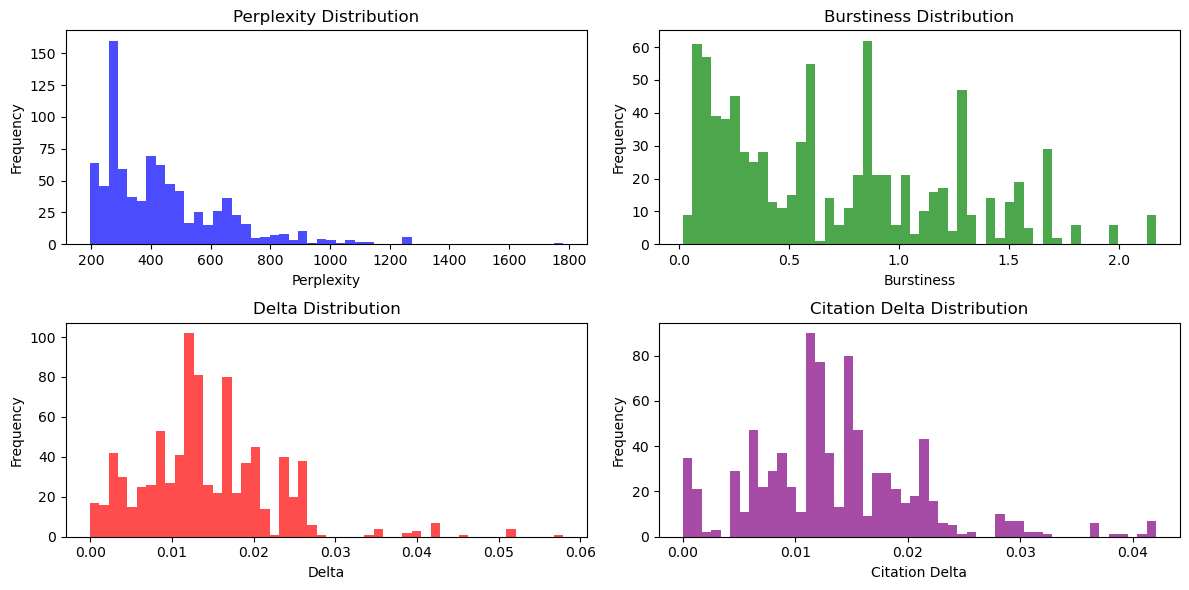

In [46]:
# read file and plot some features
import matplotlib.pyplot as plt
# Load the DataFrame
tiny_revs = pd.read_pickle("mini_history_politics_100_articles_every1m.pkl")
# Plot some features
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)

plt.hist(tiny_revs['perplexity'], bins=50, color='blue', alpha=0.7)
plt.title('Perplexity Distribution')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.subplot(2, 2, 2)
plt.hist(tiny_revs['burstiness'], bins=50, color='green', alpha=0.7)
plt.title('Burstiness Distribution')
plt.xlabel('Burstiness')
plt.ylabel('Frequency')
plt.subplot(2, 2, 3)
plt.hist(tiny_revs['delta'], bins=50, color='red', alpha=0.7)
plt.title('Delta Distribution')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.subplot(2, 2, 4)
plt.hist(tiny_revs['citation_delta'], bins=50, color='purple', alpha=0.7)
plt.title('Citation Delta Distribution')
plt.xlabel('Citation Delta')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
